### This notebook is used to evaluate models

In [262]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics                           
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

#### Importing data

In [281]:
tr_val=pd.read_csv("data/train_values.csv") #train_values

tr_labels=pd.read_csv("data/train_labels.csv",usecols=["status_group"]) #train_values  59,400
train=pd.concat([tr_val, tr_labels], axis=1) # train

test=pd.read_csv("data/test_values.csv") #test_values 14,850

df_all= pd.concat([train, test]).reset_index(drop=True) #concatinating train and test data frames  

Eventhough spliting date_recorded gives three column it didn't contribute to any accuracy gain 

In [282]:
# df_all['date_recorded']= pd.to_datetime(df_all['date_recorded'],format='%Y-%m-%d') #changing the datatype of the date_recorded feature
# df_all['ryear'] = pd.DatetimeIndex(df_all['date_recorded']).year  #split date column to year, month , and day
# df_all['rmonth'] = pd.DatetimeIndex(df_all['date_recorded']).month
# df_all['rday'] = pd.DatetimeIndex(df_all['date_recorded']).day  

#### Below features were selected from Sequential feature selection

In [283]:
features_set1=['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'basin', 'subvillage', 'region',
       'district_code', 'lga', 'ward', 'population', 'scheme_management',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management_group', 'payment', 'water_quality',
       'quality_group', 'quantity', 'source', 'source_class',
       'waterpoint_type','ryear','rmonth','rday','status_group']
                                                                #These feature set was selected from SFS only using label 
                                                                # encoding and filling missing numerical missing by -1
                                                                # and cat ones by 'missing' submission score= 82.2340

features_set2=['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'region', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'permit', 'construction_year',
       'extraction_type_group', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_type','status_group']
                                                                # These feature set was selected from SFS,and droped some columns 
                                                                # using the insights got from Exploratory analysis,label 
                                                                # encoding used and filled missing numerical missing by mean
                                                                # and categorical ones by most frequent and "Unkown" values submission score= 81.29

In [284]:
# df=df_all[features_set1]
df=df_all[features_set2]

#### Dealing with missing values

In [285]:
df_all.isna().sum().sort_values(ascending=False)#misssing values

scheme_name              35258
status_group             14850
scheme_management         4846
installer                 4532
funder                    4504
public_meeting            4155
permit                    3793
subvillage                 470
latitude                     0
quantity                     0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity_group               0
extraction_type_group        0
source                       0
source_type                  0
source_class                 0
waterpoint_type              0
waterpoint_type_group        0
extraction_type_class        0
extraction_type              0
wpt_name                     0
construction_year            0
gps_height                   0
date_recorded                0
amount_tsh                   0
recorded_by                  0
longitude                    0
populati

#### filling 0 and null values in funder and installer with "Unknown"

In [286]:
df['funder'].fillna(value='Unknown',inplace=True)
df['funder'].replace(to_replace = '0', value ='Unknown' , inplace=True)

C:\Users\CSE\anaconda3\envs\tf\lib\site-packages\pandas\core\generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\Users\CSE\anaconda3\envs\tf\lib\site-packages\pandas\core\generic.py:6610: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [287]:
df['installer'].fillna(value='Unknown',inplace=True)  
df['installer'].replace(to_replace = '0', value ='Unknown' , inplace=True) 

In [288]:
# Correcting spelling errors
df['installer'].replace(to_replace = ('Unisef','UNICEF'),value ='Unicef' , inplace=True)
df['installer'].replace(to_replace = 'DANID', value ='DANIDA' , inplace=True)
df['installer'].replace(to_replace = ( 'villager', 'Villagers','villigers', 'Villa', 'Village', 'Villi', 
                                      'Village Council','Village Counil',  'Vill','Villages', 'Village community', 
                                      'Villaers', 'Village Community', 'Villag','Villege Council', 'Village council',
                                      'Village Technician','Village  Council','Villagerd', 'Villager',
                                      'Village Office','Village community members'),
                                        value ='villagers' , inplace=True)
df['installer'].replace(to_replace =('COMMU','Commu','Communit','commu', 'COMMUNITY') ,
                                        value ='Community' , inplace=True)
df['installer'].replace(to_replace = ( 'GOVER', 'GOVERNME','GOVERNMENT', 'GOVERM','GOVERN','Gover','Gove',
                                      'Governme','Governmen' ) ,value ='Government' , inplace=True)
df['installer'].replace(to_replace = 'Hesawa' ,value ='HESAWA' , inplace=True)
df['installer'].replace(to_replace = ('Colonial Government') , value ='Colonial government' , inplace=True)
df['installer'].replace(to_replace = ('Government of Misri') , value ='Misri Government' , inplace=True)
df['installer'].replace(to_replace = ('Italy government') , value ='Italian government' , inplace=True)
df['installer'].replace(to_replace = ('British colonial government') , value ='British government' , inplace=True)
df['installer'].replace(to_replace = ('Concern /government') , value ='Concern/Government' , inplace=True)
df['installer'].replace(to_replace = ('District Water Department', 'District water depar','Distric Water Department'),
                        value ='District water department' , inplace=True)
df['installer'].replace(to_replace = ('FinW','Fini water','FINI WATER'), value ='Fini Water' , inplace=True)
df['installer'].replace(to_replace = 'JAICA', value ='Jaica' , inplace=True)
df['installer'].replace(to_replace = ( 'District COUNCIL','COUN', 'DISTRICT COUNCIL', 
                                      'District Council','District Counci','Council','Counc','District  Council','Distri'),
                                    value ='District council' , inplace=True)
df['installer'].replace(to_replace = ( 'RC Churc', 'RC CHURCH','RC','RC C','RC Ch', 'RC CH','RC church', 
                                      'RC CATHORIC',) , value ='RC Church' , inplace=True)
df['installer'].replace(to_replace = ('Tanzanian Government','Tanzania Government','Central Government',
                                       'central government','Cental Government','Cebtral Government',
                                       'Centra Government' ,'CENTRAL GOVERNMENT', 'TANZANIAN GOVERNMENT','Central govt', 'Centr', 
                                      'Tanzania government','Centra govt') , value ='Central government' , inplace=True)
df['installer'].replace(to_replace = ('World vision', 'World Division','World Vision'),
                                        value ='world vision' , inplace=True)

df['installer'].replace(to_replace = ('Cetral government /RC') , value ='RC church/Central Gover' , inplace=True)
df['installer'].replace(to_replace = ('Government /TCRS','Government/TCRS') , value ='TCRS /Government' , inplace=True)
df['installer'].replace(to_replace = ('Village Government') , value ='Village government' , inplace=True)
df['installer'].replace(to_replace = ('Government and Community') , value ='Government /Community' , inplace=True)
df['installer'].replace(to_replace = ('ADRA /Government') , value ='ADRA/Government' , inplace=True)

In [289]:
num_cols = list(df.select_dtypes('number').columns)
num_cols

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'district_code',
 'population',
 'construction_year']

In [290]:
cat_cols = list(df.select_dtypes('object').columns)
cat_cols.remove('status_group') #remove target column from categorical columns

#### Filling missing numerical values by mean(if any)

In [291]:
for col in num_cols:
#     df[col].fillna(value=-1,inplace=True) #fill using -1
    df[col].fillna(df[col].mean(), inplace=True)  #fill using column mean 

#### Filling missing categorical values bymost frequent category (if any)

In [292]:
for col in (cat_cols):
#     df[col] = df[col].fillna(value='missing')
    df[col] = df[col].fillna(df[col].value_counts().index[0])


C:\Users\CSE\anaconda3\envs\tf\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


#### Label encoding

In [293]:
labelencoder = LabelEncoder()
from category_encoders import OrdinalEncoder as oe
for col in (cat_cols):
    df[col]=labelencoder.fit_transform(df[col])


In [294]:
#### Get some insight about correlation with target value

In [295]:
# corr=df[:59400].corr()["status_group"].sort_values(ascending=False)
# print((corr[:]))

### Graphs used to analyze outliers

In [321]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

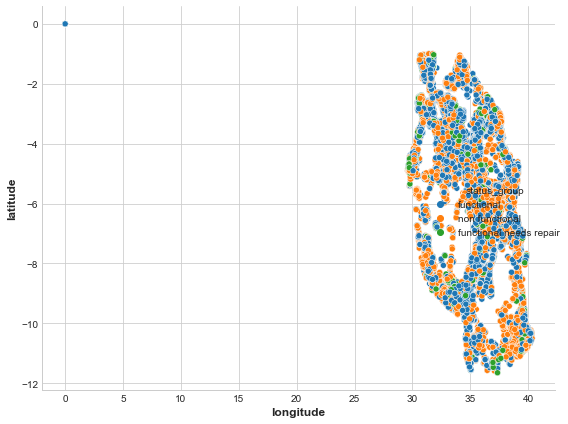

In [323]:
sns.relplot(
    x="longitude", y="latitude", hue="status_group", data=df, height=6,
);

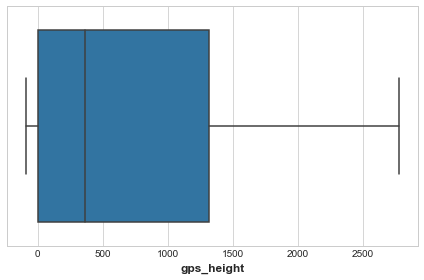

In [324]:
ax = sns.boxplot(x=df['gps_height'])

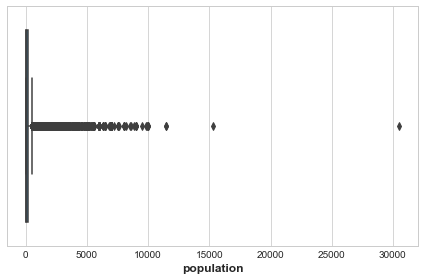

In [328]:
ax = sns.boxplot(x=df['population'])

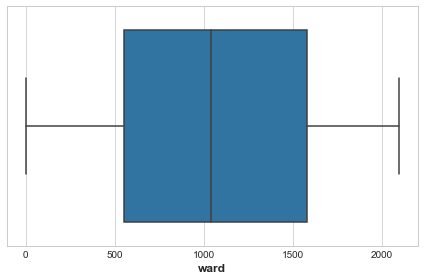

In [326]:
ax = sns.boxplot(x=df['ward'])

#### Scaling the selected features before create PCA feature

In [303]:
# scaled_feat=['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
#        'latitude', 'basin', 'region', 'district_code', 'lga', 'ward',
#        'population', 'public_meeting', 'permit', 'construction_year',
#        'extraction_type_group', 'management', 'payment', 'water_quality',
#        'quantity', 'source', 'waterpoint_type']
# scaler = StandardScaler()
# scaler.fit(df.drop('status_group',axis=1))
# scaled_features = scaler.transform(df.drop('status_group',axis=1))
# scaled_features
# df_feat1 = pd.DataFrame(scaled_features,columns=scaled_feat)
# df_feat1.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,...,public_meeting,permit,construction_year,extraction_type_group,management,payment,water_quality,quantity,source,waterpoint_type
0,1.954529,0.767624,1.045581,1.100841,0.131432,-1.410738,-1.248926,-1.153202,-0.065246,-0.256009,...,0.305705,-1.548552,0.735593,-0.836318,-0.130260,-0.138378,0.273091,-0.405719,0.951664,-0.884097
1,-0.109637,-0.747861,1.058572,-0.488058,0.095018,1.206916,-0.035157,-0.141830,-0.376399,1.218788,...,0.305705,0.645764,0.747143,-0.836318,1.821369,-1.019824,0.273091,0.839667,-0.521454,-0.884097
2,-0.101036,-0.154075,0.029350,2.087817,0.515240,0.638531,0.369433,-0.310392,-0.168964,1.360596,...,0.305705,0.645764,0.746093,-0.836318,-0.130260,0.743068,0.273091,-0.405719,-2.976652,-0.323107
3,-0.109637,1.377658,-0.581254,1.670307,0.671269,-1.851824,1.178612,0.363855,5.950371,0.765005,...,0.305705,0.645764,0.721942,1.714363,-0.130260,-1.019824,0.273091,-1.651105,-1.503533,-0.323107
4,-0.109637,-1.489355,-0.960897,-1.137191,-0.447840,1.316292,-0.035157,-0.984640,-0.480117,-0.965046,...,0.305705,0.645764,-1.363441,-0.836318,-3.057703,-1.019824,0.273091,2.085053,-0.521454,-0.884097


#### Create PCA feature using selected 4 featuers

In [304]:
# from sklearn.decomposition import PCA 
# pca = PCA(n_components=1)
# pca.fit(df_feat1)
# x_pca = pca.transform(df_feat1)

In [99]:
# x_pca.shape

In [305]:
# df_feat2=pd.DataFrame(x_pca) # combining PCA feature with 4 features selected
# df_feat=df.join(df_feat2)
# df_feat

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,...,construction_year,extraction_type_group,management,payment,water_quality,quantity,source,waterpoint_type,status_group,0
0,6000.0,1547,1390,1648,34.938093,-9.856322,1,3,5,51,...,1999,1,7,2,6,1,8,1,functional,1.756698
1,0.0,521,1399,571,34.698766,-2.147466,4,9,2,103,...,2010,1,11,0,6,2,5,1,functional,1.081373
2,25.0,923,686,2317,37.460664,-3.821329,5,8,4,108,...,2009,1,7,4,6,1,0,2,functional,0.827493
3,0.0,1960,263,2034,38.486161,-11.155298,7,12,63,87,...,1986,10,7,0,6,0,3,2,non functional,0.611763
4,0.0,19,0,131,31.130847,-1.825359,4,4,1,26,...,0,1,1,0,6,3,5,1,functional,-0.352617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74245,0.0,292,34,433,38.852669,-6.582841,8,14,1,3,...,1988,4,7,0,6,1,6,1,NaN,0.662617
74246,1000.0,583,0,628,37.451633,-5.350428,5,20,7,33,...,1994,5,7,2,4,2,7,4,NaN,-0.217779
74247,0.0,1972,1476,2035,34.739804,-4.585587,0,18,2,109,...,2010,1,7,0,6,2,0,1,NaN,0.318549
74248,0.0,481,998,419,35.432732,-10.584159,1,16,2,111,...,2009,1,7,0,6,2,6,1,NaN,1.409532


#### Create cluster feature

In [317]:
# Create cluster feature

# kmeans = KMeans(n_clusters=10)
# df["Cluster"] = kmeans.fit_predict(X1)
# df["Cluster"] = df["Cluster"].astype("category")

# df.status_group

#### Creating train and test datasets

In [318]:
X = df[:59400].copy()
y=X.pop('status_group')
y=train.status_group #uncomment if use correlation matrix and remove statues_group from cat_feat
X_eval = df[59400:].copy()
X_eval.pop('status_group')

59400    NaN
59401    NaN
59402    NaN
59403    NaN
59404    NaN
        ... 
74245    NaN
74246    NaN
74247    NaN
74248    NaN
74249    NaN
Name: status_group, Length: 14850, dtype: object

#### Evaluating models
#### 1. Random forest

In [312]:
def get_acc_rf(X,y):
    rf=RandomForestClassifier(criterion='gini',   
                          min_samples_split=5,   
                          min_samples_leaf=1,
                          max_features='auto',
                          oob_score=False,
                          random_state=1,
                           n_jobs=-1
                          )
    score=cross_val_score(rf,X,y,cv=5)
    
#   print("score",score)
    print("mean_score",score.mean())
    return score.mean()
get_acc_rf(X,y)

mean_score 0.8115656565656566


0.8115656565656566

#### 2. XGBoost

In [205]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

def get_acc_xg(X,y):
    xgboost=xgb.XGBClassifier(objective ="multi:softmax",
                              colsample_bytree = 0.01,
                              learning_rate = 0.001, max_depth = 6,
                              alpha = 0.1,
#                               num_class=, #number of classes
                              n_estimators = 100 )
    score=cross_val_score(xgboost,X,y,cv=5)
    
#     print("score",score)
    print("mean_score",score.mean())
    return score.mean()
get_acc_xg(X,y)

C:\Users\CSE\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:05:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\CSE\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:06:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\CSE\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:06:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\CSE\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\CSE\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
mean_score 0.583939393939394


0.583939393939394

#### 3. Cat boost

In [206]:
cat=CatBoostClassifier( verbose=False, iterations=1500,
    learning_rate=0.2053434310118264,
    random_strength=8,
    bagging_temperature=0,
    max_bin=20,
    grow_policy="Depthwise",
    min_data_in_leaf=10,
    max_depth=3,
    l2_leaf_reg=9.501510078266123e-06,
    one_hot_max_size=500,
    auto_class_weights="SqrtBalanced")

score=cross_val_score(cat,X,y,cv=5)
print("mean_score",score.mean())

mean_score 0.7774242424242425


#### 4. KNN

In [215]:
from sklearn.model_selection import cross_val_score

accuracy_rate={}

for i in range(1,50):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    score=cross_val_score(knn,X,y,cv=5)
    accuracy_rate[i]=score.mean()
    print(score.mean())

0.6755555555555556
0.707979797979798
0.7170202020202019
0.7246127946127946
0.7297138047138046
0.7319023569023569
0.7291582491582491
0.7283333333333333
0.7266666666666667
0.7263131313131312
0.7275757575757575
0.7251515151515152
0.7245454545454545
0.7224915824915825
0.7215656565656566
0.7183164983164984
0.7178619528619528
0.7175084175084174
0.717020202020202
0.7162794612794613
0.7149494949494949
0.715016835016835
0.713956228956229
0.7117845117845117
0.710976430976431
0.7095959595959596
0.7092592592592594
0.7076936026936027
0.7082154882154883
0.7070707070707071
0.7055723905723905
0.70503367003367
0.7029124579124579
0.7027946127946127
0.7008249158249158
0.7001851851851852
0.6998653198653197
0.7003030303030303
0.6986868686868687
0.6983501683501684
0.6974410774410774
0.6970033670033671
0.6964814814814815
0.6968181818181818
0.6953030303030303
0.6947643097643097
0.6941919191919192
0.6926767676767677
0.692020202020202


### Creating submission file

In [233]:
rf=RandomForestClassifier(criterion='gini',   
                          min_samples_split=5,
                          min_samples_leaf=1,
                          max_features='auto',
                          oob_score=False,
                          random_state=1,
                           n_jobs=-1)
rf.fit(X,y)

RandomForestClassifier(min_samples_split=5, n_jobs=-1, random_state=1)

In [234]:
pred=rf.predict(X_eval)
sub_df=pd.read_csv("data/SubmissionFormat.csv",index_col="id")
sub_df['status_group']=pred
sub_df.to_csv("submission_file_final5.csv")
    
# getSubmisionFile(clf,test_set) 
len(pred)

14850